This code includes the following:
#Data Preparation and EDA:

We gathered and cleaned the data from the ATNF Pulsar Catalogue.
Performed exploratory data analysis to understand distributions, correlations, and anomalies.

#Unsupervised Clustering:

Applied various clustering techniques (K-Means, DBSCAN, and Hierarchical Clustering) to classify neutron stars.
Evaluated clustering performance using silhouette scores.
Applied dimensionality reduction with autoencoders and then used DBSCAN, leading to the highest silhouette score of 0.753.

#Cluster Analysis:

Analyzed the characteristics of the identified clusters.
Provided distributions of key features (P0, P1, F0, F1) within each cluster.
Identified the cluster distribution and properties, including noise and meaningful clusters.

#Visualization:

Created visualizations of the clusters in different feature spaces and the encoded space.
Planned additional visualizations to enhance the interpretation of clusters.

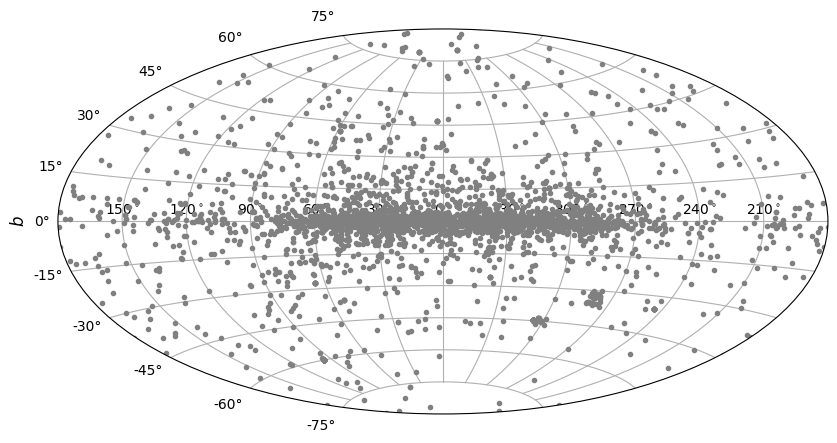

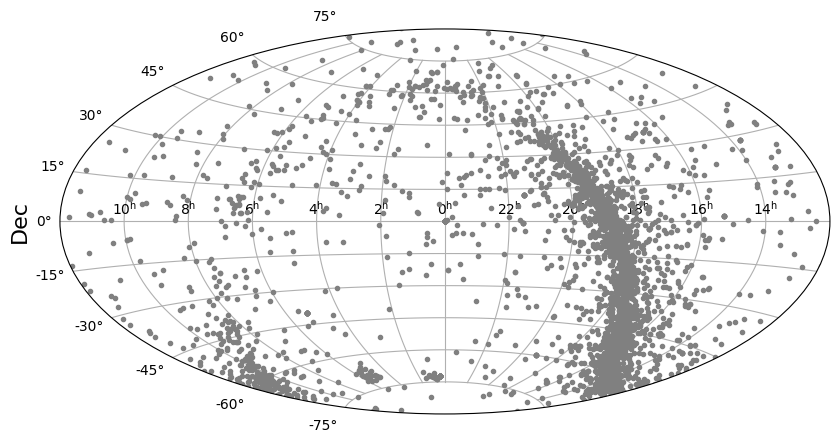

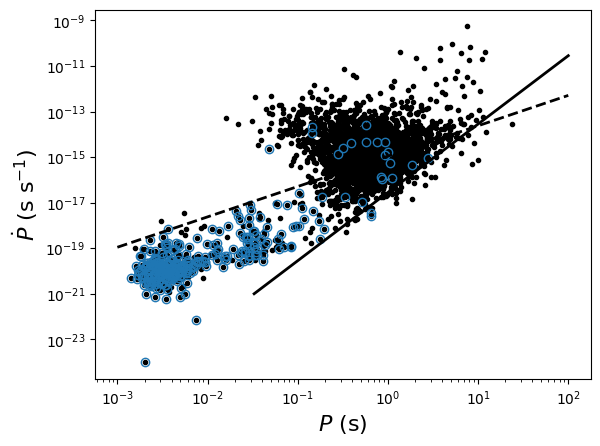

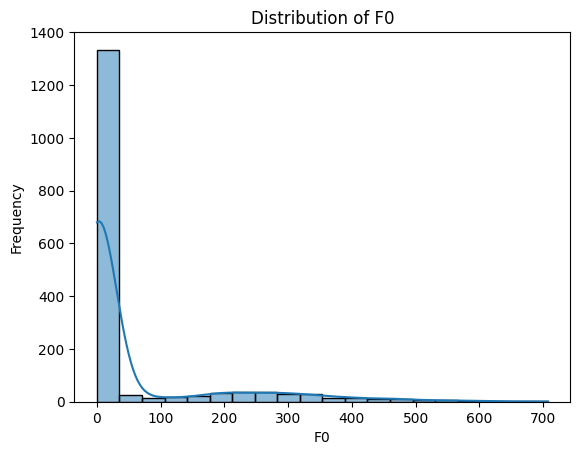

In [2]:
import astropy
from astropy.table import Table, Column, MaskedColumn
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import tarfile
from astropy import units as u

# Download and extract the tar.gz file
pulsargzfile = urllib.request.urlopen('http://www.atnf.csiro.au/people/pulsar/psrcat/downloads/psrcat_pkg.tar.gz')
outputgzfile = open('psrcat_pkg.tar.gz', 'wb')
outputgzfile.write(pulsargzfile.read())
outputgzfile.close()
pulsargzfile.close()

pulsargz = tarfile.open('psrcat_pkg.tar.gz', 'r')
pulsargz.extractall()
pulsargz.close()

# Function to determine data types
def getType(value):
    tests = [
        (float, float),
        (int, int),
        (str, lambda value: value.strip())  # Adjusted for string type
    ]
    for typ, test in tests:
        try:
            test(value)
            return typ
        except ValueError:
            continue
    # No match
    return str

# Read and process the database file
psrcatdb = 'psrcat_tar/psrcat.db'
breakstring = '@-----------------------------------------------------------------'
commentstring = '#'
versionstring = '#CATALOGUE'

datafile = open(psrcatdb)
psrtable = Table(masked=True)
ind = 0
masking = []

for line in datafile:
    dataline = line.split()
    if dataline[0] == breakstring or dataline[0] == commentstring or dataline[0] == versionstring:
        if dataline[0] == breakstring:
            psrtable.add_row(None)
            ind += 1
            psrtable.mask[ind] = masking
        continue

    if dataline[0] not in psrtable.colnames:
        masking.append(True)
        thisdatatype = getType(dataline[1])
        if thisdatatype == float:
            thisdtstr = 'f4'
        elif thisdatatype == int:
            thisdtstr = 'i2'
        else:
            thisdtstr = 'S100'
        newcolumn = MaskedColumn(name=dataline[0], dtype=thisdtstr, mask=True, length=ind + 1)
        psrtable.add_column(newcolumn)

    psrtable[dataline[0]][ind] = dataline[1]
    psrtable[dataline[0]].mask[ind] = False

datafile.close()

# Convert frequencies and derivatives into periods and derivatives
for obj in range(len(psrtable)):
    if not psrtable['F0'].mask[obj]:
        if psrtable['P0'].mask[obj]:
            psrtable['P0'].mask[obj] = False
            psrtable['P0'][obj] = 1.0 / psrtable['F0'][obj]
        if not psrtable['F1'].mask[obj]:
            if psrtable['P1'].mask[obj]:
                psrtable['P1'].mask[obj] = False
                psrtable['P1'][obj] = (-1.0 * psrtable['F1'][obj]) / (psrtable['F0'][obj] ** 2)

# Ensure RAJ and DECJ columns are strings and correctly formatted
psrtable['RAJ'] = psrtable['RAJ'].astype(str)
psrtable['DECJ'] = psrtable['DECJ'].astype(str)

# Convert coordinates from string to SkyCoord
psrtable['coord'] = SkyCoord(psrtable['RAJ'], psrtable['DECJ'], unit=(u.hourangle, u.deg))

# Plotting
# 1. Aitoff projection for Galactic coordinates
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
ax.grid(True)
ax.plot(-1 * psrtable['coord'].galactic.l.radian, psrtable['coord'].galactic.b.radian, '.', color='0.5')
ax.plot(2 * np.pi - psrtable['coord'].galactic.l.radian, psrtable['coord'].galactic.b.radian, '.', color='0.5')
ax.set_xticklabels([
    r'$150^\circ$', r'$120^\circ$', r'$90^\circ$', r'$60^\circ$',
    r'$30^\circ$', r'$0^\circ$', r'$330^\circ$', r'$300^\circ$',
    r'$270^\circ$', r'$240^\circ$', r'$210^\circ$'
])
plt.ylabel(r'$b$', fontsize=12)
plt.show()

# 2. Aitoff projection for Equatorial coordinates
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='aitoff')
ax.grid(True)
ax.plot(-1 * psrtable['coord'].ra.radian, psrtable['coord'].dec.radian, '.', color='0.5')
ax.plot(2 * np.pi - psrtable['coord'].ra.radian, psrtable['coord'].dec.radian, '.', color='0.5')
ax.set_xticklabels([
    r'$10^{\rm h}$', r'$8^{\rm h}$', r'$6^{\rm h}$', r'$4^{\rm h}$',
    r'$2^{\rm h}$', r'$0^{\rm h}$', r'$22^{\rm h}$', r'$20^{\rm h}$',
    r'$18^{\rm h}$', r'$16^{\rm h}$', r'$14^{\rm h}$'
])
plt.ylabel(r'Dec', fontsize=16)
plt.show()

# 3. P-Pdot diagram
fig = plt.figure()
ax = plt.gca()
ax.plot(psrtable['P0'], psrtable['P1'], '.', c='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(psrtable['P0'][psrtable['BINARY'].mask == False],
        psrtable['P1'][psrtable['BINARY'].mask == False], 'o', mfc='None')
ax.plot([0.0328449, 100], [1.0E-21, 2.8223E-11], color='k', linestyle='-', linewidth=2)
ax.plot([1.E-3, 1.E2], [1.1E-19, 5.1E-13], color='k', linestyle='--', linewidth=2)
plt.xlabel(r'$P\ {\rm(s)}$', fontsize=16)
plt.ylabel(r'$\dot{P}\ {\rm(s\ s^{-1})}$', fontsize=16)
plt.show()

# 4. Distribution plot using seaborn
sns.histplot(psrtable['F0'].compressed(), bins=20, kde=True)
plt.xlabel('F0')
plt.ylabel('Frequency')
plt.title('Distribution of F0')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.6827818751335144


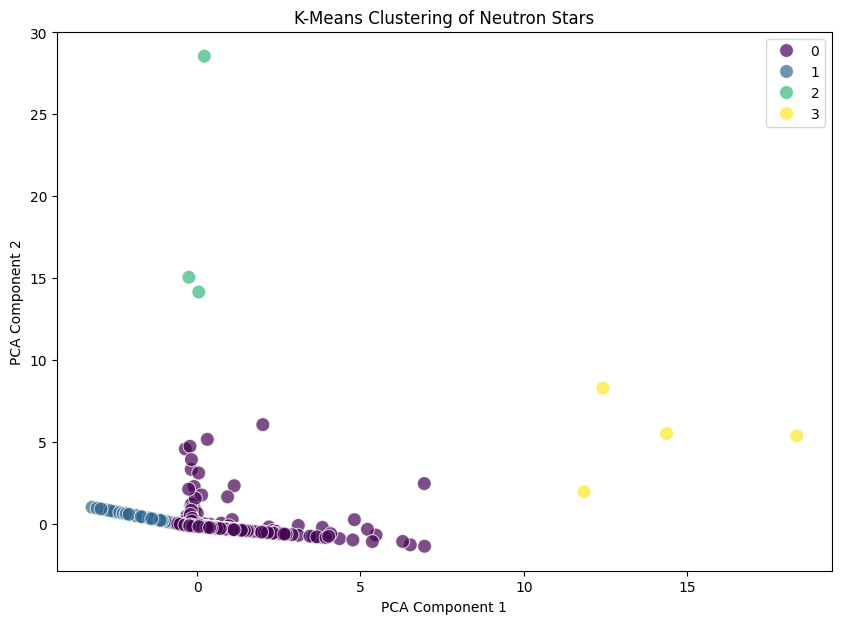

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant features and drop rows with missing values
features = ['P0', 'P1', 'F0', 'F1']
data = psrtable[features].to_pandas()
data = data.dropna()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Evaluation of Clusters
silhouette_avg = silhouette_score(data_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Visualization of Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=clusters, palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clustering of Neutron Stars')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Hierarchical Clustering Silhouette Score: 0.6735705733299255


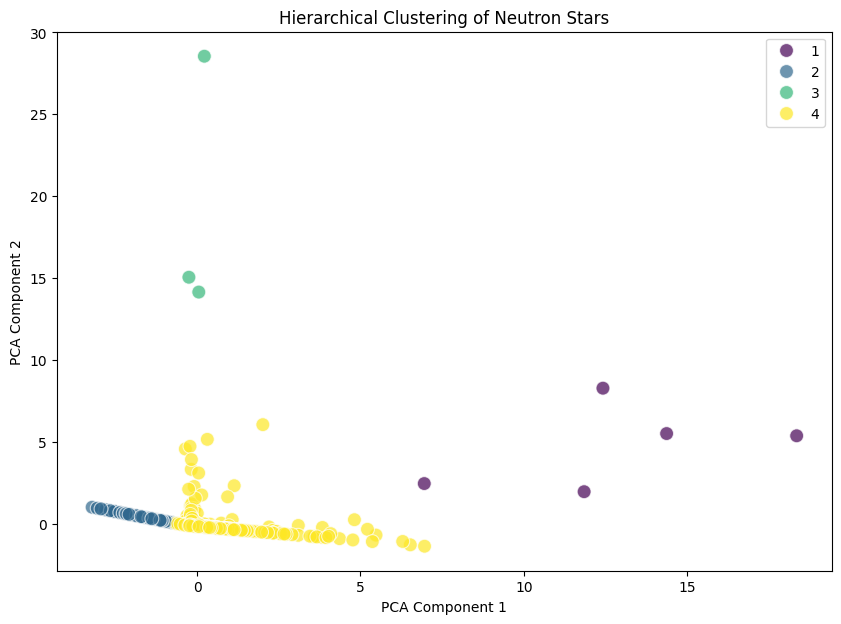

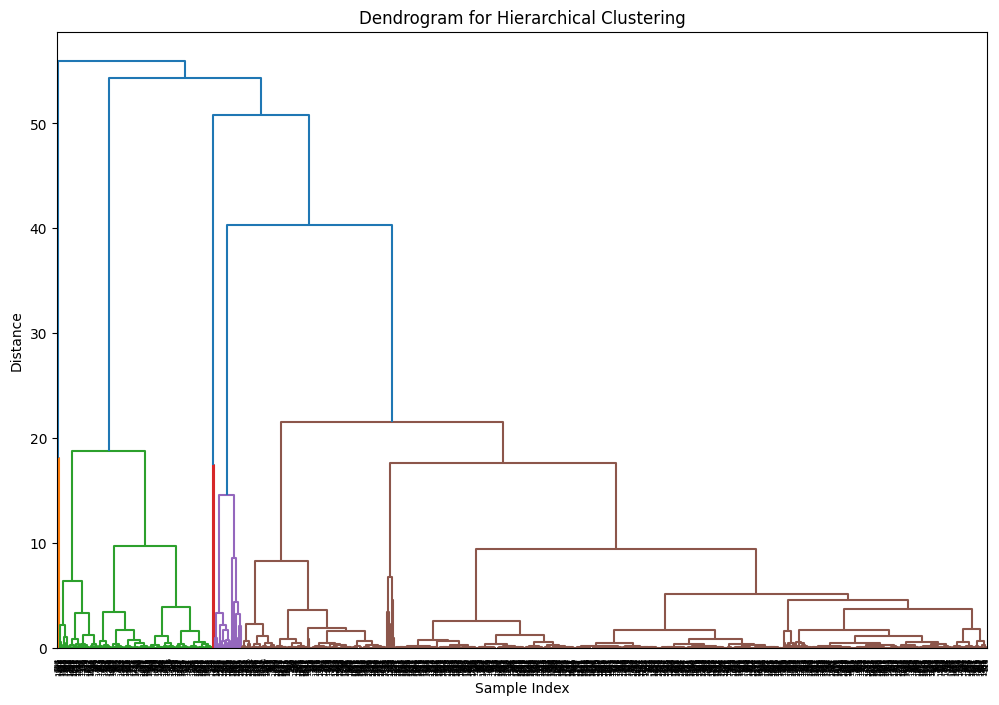

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Hierarchical Clustering
Z = linkage(data_scaled, method='ward')
hier_clusters = fcluster(Z, t=4, criterion='maxclust')

# Evaluation of Hierarchical Clusters
silhouette_avg_hier = silhouette_score(data_scaled, hier_clusters)
print(f'Hierarchical Clustering Silhouette Score: {silhouette_avg_hier}')

# Visualization of Hierarchical Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=hier_clusters, palette='viridis', s=100, alpha=0.7)
plt.title('Hierarchical Clustering of Neutron Stars')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


DBSCAN Silhouette Score: 0.7339337468147278


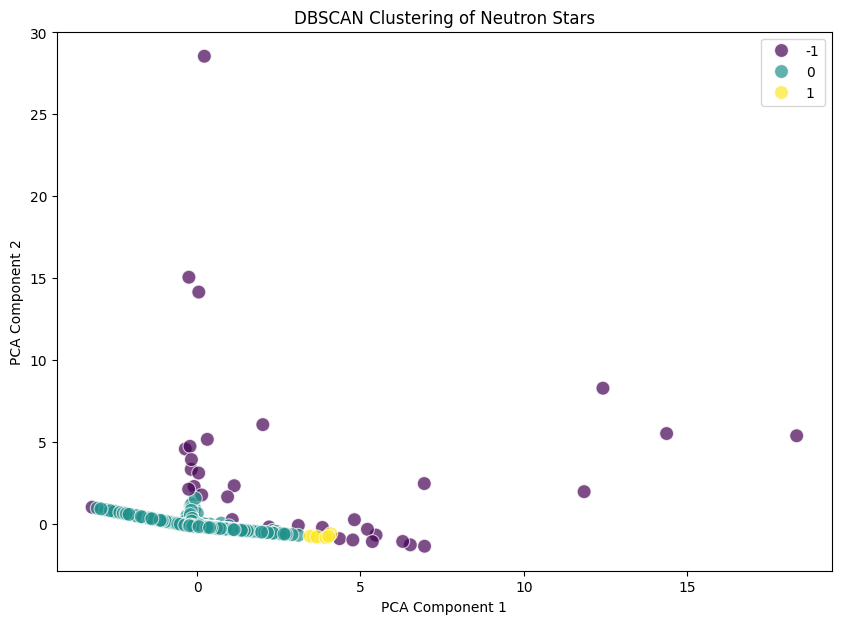

In [4]:
from sklearn.cluster import DBSCAN

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(data_scaled)

# Evaluation of DBSCAN Clusters
silhouette_avg_dbscan = silhouette_score(data_scaled, dbscan_clusters)
print(f'DBSCAN Silhouette Score: {silhouette_avg_dbscan}')

# Visualization of DBSCAN Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=dbscan_clusters, palette='viridis', s=100, alpha=0.7)
plt.title('DBSCAN Clustering of Neutron Stars')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Detailed Analysis of DBSCAN clustering

Cluster Distribution: {-1: 34, 0: 1593, 1: 8}
               P0            P1         F0            F1
cluster                                                 
-1       3.901096  5.864260e-12  28.753023 -3.857347e-11
 0       0.644499  1.391066e-14  53.076191 -2.494105e-13
 1       6.654528  2.360560e-13   0.150528 -5.166234e-15


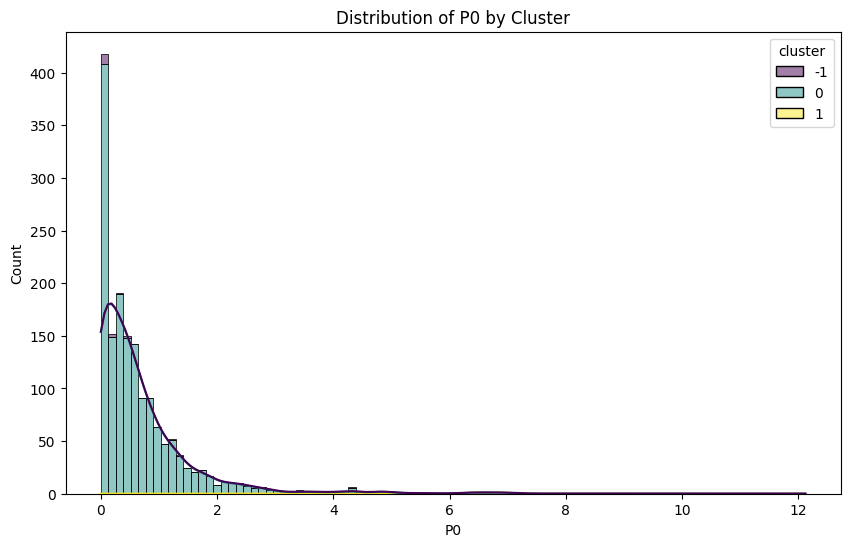

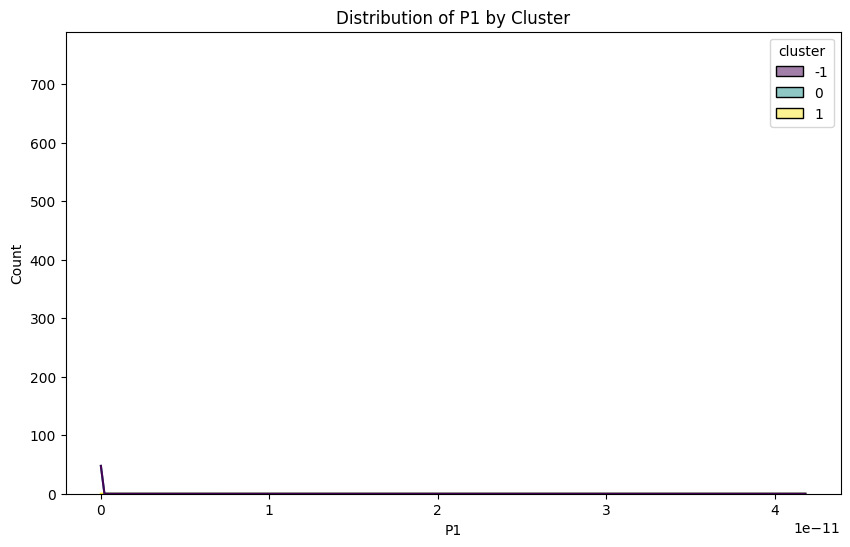

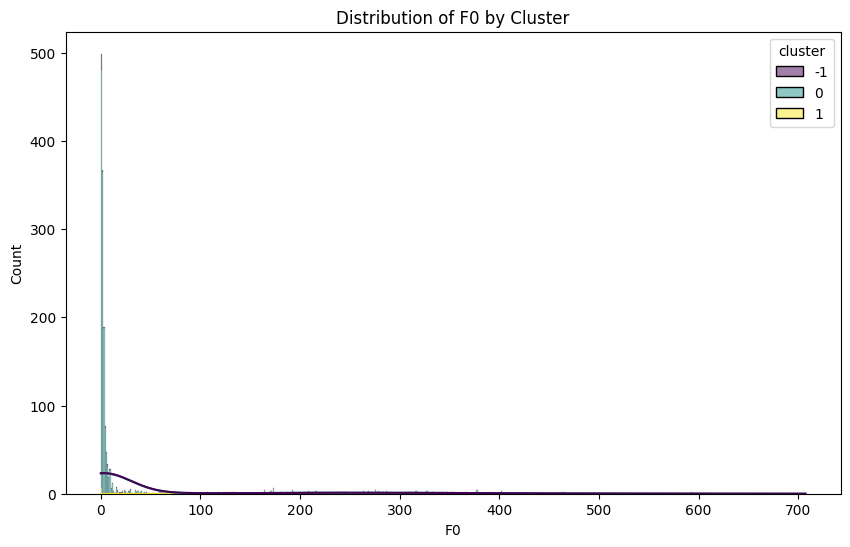

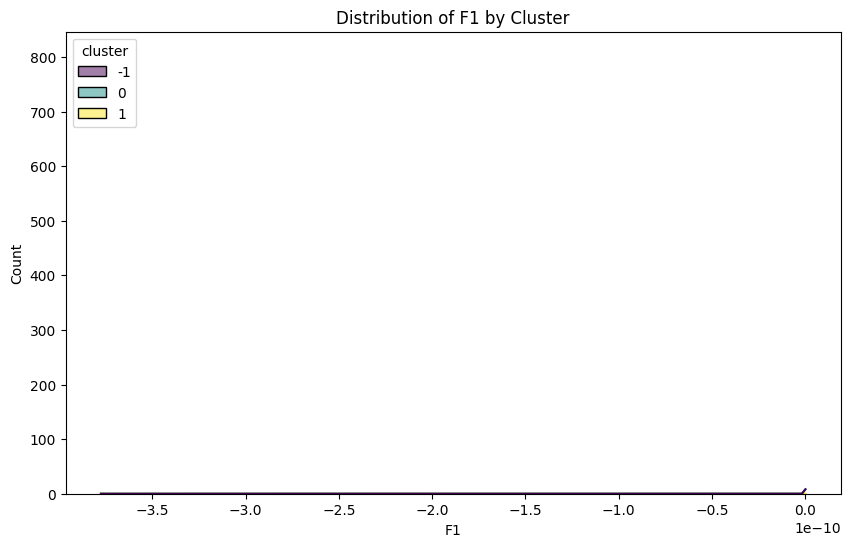

In [6]:
# Analyze cluster distribution
unique, counts = np.unique(dbscan_clusters, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f'Cluster Distribution: {cluster_distribution}')

# Add clusters to the dataframe
data['cluster'] = dbscan_clusters

# Analyze properties of each cluster
cluster_summary = data.groupby('cluster').mean()
print(cluster_summary)

# Visualize distributions of features within each cluster
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='cluster', multiple='stack', palette='viridis', kde=True)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()


Dimensionality Reduction with Autoencoders

52/52 [==============================] - 0s 1ms/step
Autoencoder + K-Means Silhouette Score: 0.75527423620224


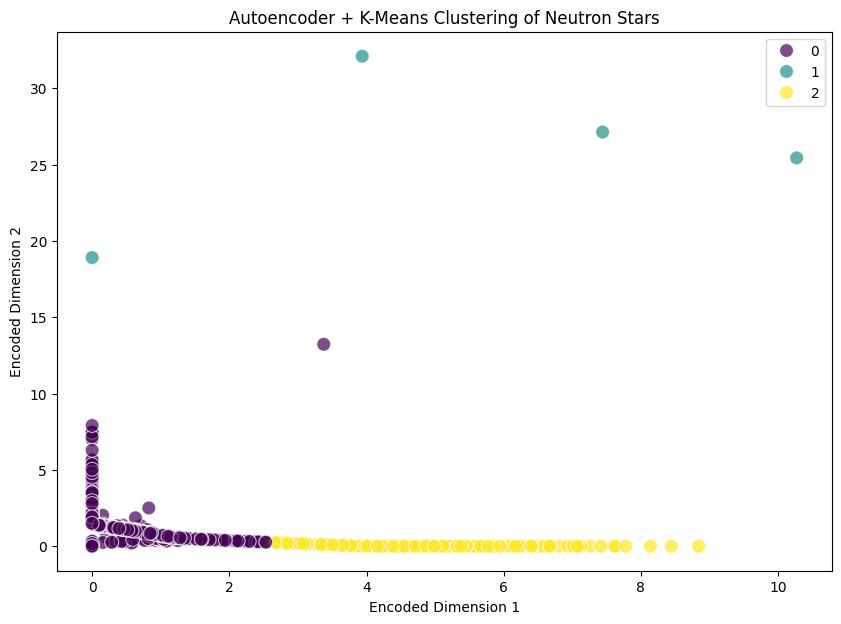

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define the autoencoder model
input_dim = data_scaled.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
encoder_model = Model(inputs=input_layer, outputs=encoder)

autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=0)

# Encode the data
encoded_data = encoder_model.predict(data_scaled)

# K-Means Clustering on encoded data
kmeans_encoded = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters_encoded = kmeans_encoded.fit_predict(encoded_data)

# Evaluation of Clusters on encoded data
silhouette_avg_encoded = silhouette_score(encoded_data, clusters_encoded)
print(f'Autoencoder + K-Means Silhouette Score: {silhouette_avg_encoded}')

# Visualization of Clusters on encoded data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=clusters_encoded, palette='viridis', s=100, alpha=0.7)
plt.title('Autoencoder + K-Means Clustering of Neutron Stars')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()


Autoencoder + DBSCAN Silhouette Score: 0.7532592415809631


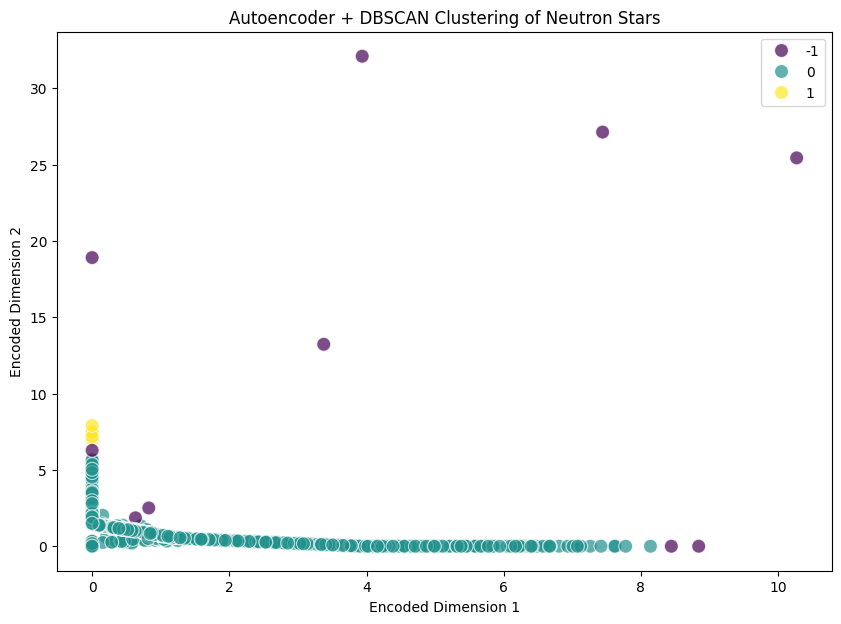

Cluster Distribution (Autoencoder + DBSCAN): {-1: 10, 0: 1619, 1: 6}
                              P0            P1          F0            F1  \
cluster_encoded_dbscan                                                     
-1                      4.608515  1.615377e-11  138.043976 -2.776793e-12   
 0                      0.685827  3.072836e-14   51.975327 -1.038180e-12   
 1                      9.353352  2.024343e-12    0.114250 -4.491985e-14   

                         cluster  
cluster_encoded_dbscan            
-1                     -0.800000  
 0                     -0.007412  
 1                     -1.000000  


"# Visualize distributions of features within each cluster\nfor feature in features:\n    plt.figure(figsize=(10, 6))\n    sns.histplot(data=data, x=feature, hue='cluster_encoded_dbscan', multiple='stack', palette='viridis', kde=True)\n    plt.title(f'Distribution of {feature} by Autoencoder + DBSCAN Cluster')\n    plt.show()"

In [12]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN on the encoded data
dbscan_encoded = DBSCAN(eps=0.5, min_samples=5)
clusters_encoded_dbscan = dbscan_encoded.fit_predict(encoded_data)

# Evaluation of DBSCAN Clusters on encoded data
silhouette_avg_encoded_dbscan = silhouette_score(encoded_data, clusters_encoded_dbscan)
print(f'Autoencoder + DBSCAN Silhouette Score: {silhouette_avg_encoded_dbscan}')

# Visualizing the DBSCAN clusters on encoded data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=clusters_encoded_dbscan, palette='viridis', s=100, alpha=0.7)
plt.title('Autoencoder + DBSCAN Clustering of Neutron Stars')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()

# Analyze cluster distribution
unique_encoded_dbscan, counts_encoded_dbscan = np.unique(clusters_encoded_dbscan, return_counts=True)
cluster_distribution_encoded_dbscan = dict(zip(unique_encoded_dbscan, counts_encoded_dbscan))
print(f'Cluster Distribution (Autoencoder + DBSCAN): {cluster_distribution_encoded_dbscan}')

# Add clusters to the dataframe
data['cluster_encoded_dbscan'] = clusters_encoded_dbscan

# Analyze properties of each cluster
cluster_summary_encoded_dbscan = data.groupby('cluster_encoded_dbscan').mean()
print(cluster_summary_encoded_dbscan)

# Following code is commented out for faster execution, un-comment to visualize distributions of features within each cluster
"""for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x=feature, hue='cluster_encoded_dbscan', multiple='stack', palette='viridis', kde=True)
    plt.title(f'Distribution of {feature} by Autoencoder + DBSCAN Cluster')
    plt.show()"""
